<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [61]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import shuffle
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, classification_report, multilabel_confusion_matrix, recall_score,precision_score,f1_score,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from random import seed
from random import randint
from tensorflow import keras
from keras import layers, models, utils, datasets
from keras import utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, GridSearchCV

In [62]:
%store -r scoring X X_val CV t t_val f h w n 

n1=X_val.shape
x_train = X
t_train = t
x_val = X_val.reshape(n1[0],h*w*3)

x_train, t_train = shuffle(x_train,t_train)
x_val,t_val = shuffle(x_val,t_val)



#### Validación cruzada 

In [63]:
#regla de oro n < sqrt(n)
modelKNN = KNeighborsClassifier(round(np.sqrt((f-1)*n)))
scoresKNN = cross_validate(modelKNN, x_train, t_train, cv=CV, scoring=scoring)
print('Media del KNN : ', np.mean(scoresKNN['test_accuracy']))

# Guarda los valores de cada fold: 
df = pd.DataFrame.from_dict(scoresKNN)
df.drop(df.iloc[:, 0:2], inplace = True, axis = 1)
df.loc[5]=[np.mean(scoresKNN['test_recall_macro']),np.mean(scoresKNN['test_precision_macro']),np.mean(scoresKNN['test_f1_macro']),np.mean(scoresKNN['test_accuracy']),np.mean(scoresKNN['test_roc_auc_ovo'])]
df.index = ["CV 1","CV 2","CV 3","CV 4","CV 5","Average"]
df.to_excel("./informe/tables/KNN.xlsx") 
print(df)

Media del KNN :  0.671111111111111
         test_recall_macro  test_precision_macro  test_f1_macro  \
CV 1              0.669444              0.705265       0.656266   
CV 2              0.666667              0.701992       0.651489   
CV 3              0.678704              0.715415       0.667568   
CV 4              0.677778              0.723554       0.662782   
CV 5              0.662963              0.717472       0.652474   
Average           0.671111              0.712740       0.658116   

         test_accuracy  test_roc_auc_ovo  
CV 1          0.669444          0.889819  
CV 2          0.666667          0.873455  
CV 3          0.678704          0.884718  
CV 4          0.677778          0.888998  
CV 5          0.662963          0.879614  
Average       0.671111          0.883321  


### Analisis hiper-parametros KNN

In [64]:
param_grid = {
    "leaf_size": list(range(1,50,10)),
    "n_neighbors": list(range(5,round(np.sqrt((f-1)*n)),8)),
    "p":[1,2]
}
search = GridSearchCV(estimator = modelKNN, param_grid =param_grid, n_jobs=-1,cv=CV,scoring=scoring,verbose=1,refit=False,return_train_score=False)
search_results = search.fit(x_train,t_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


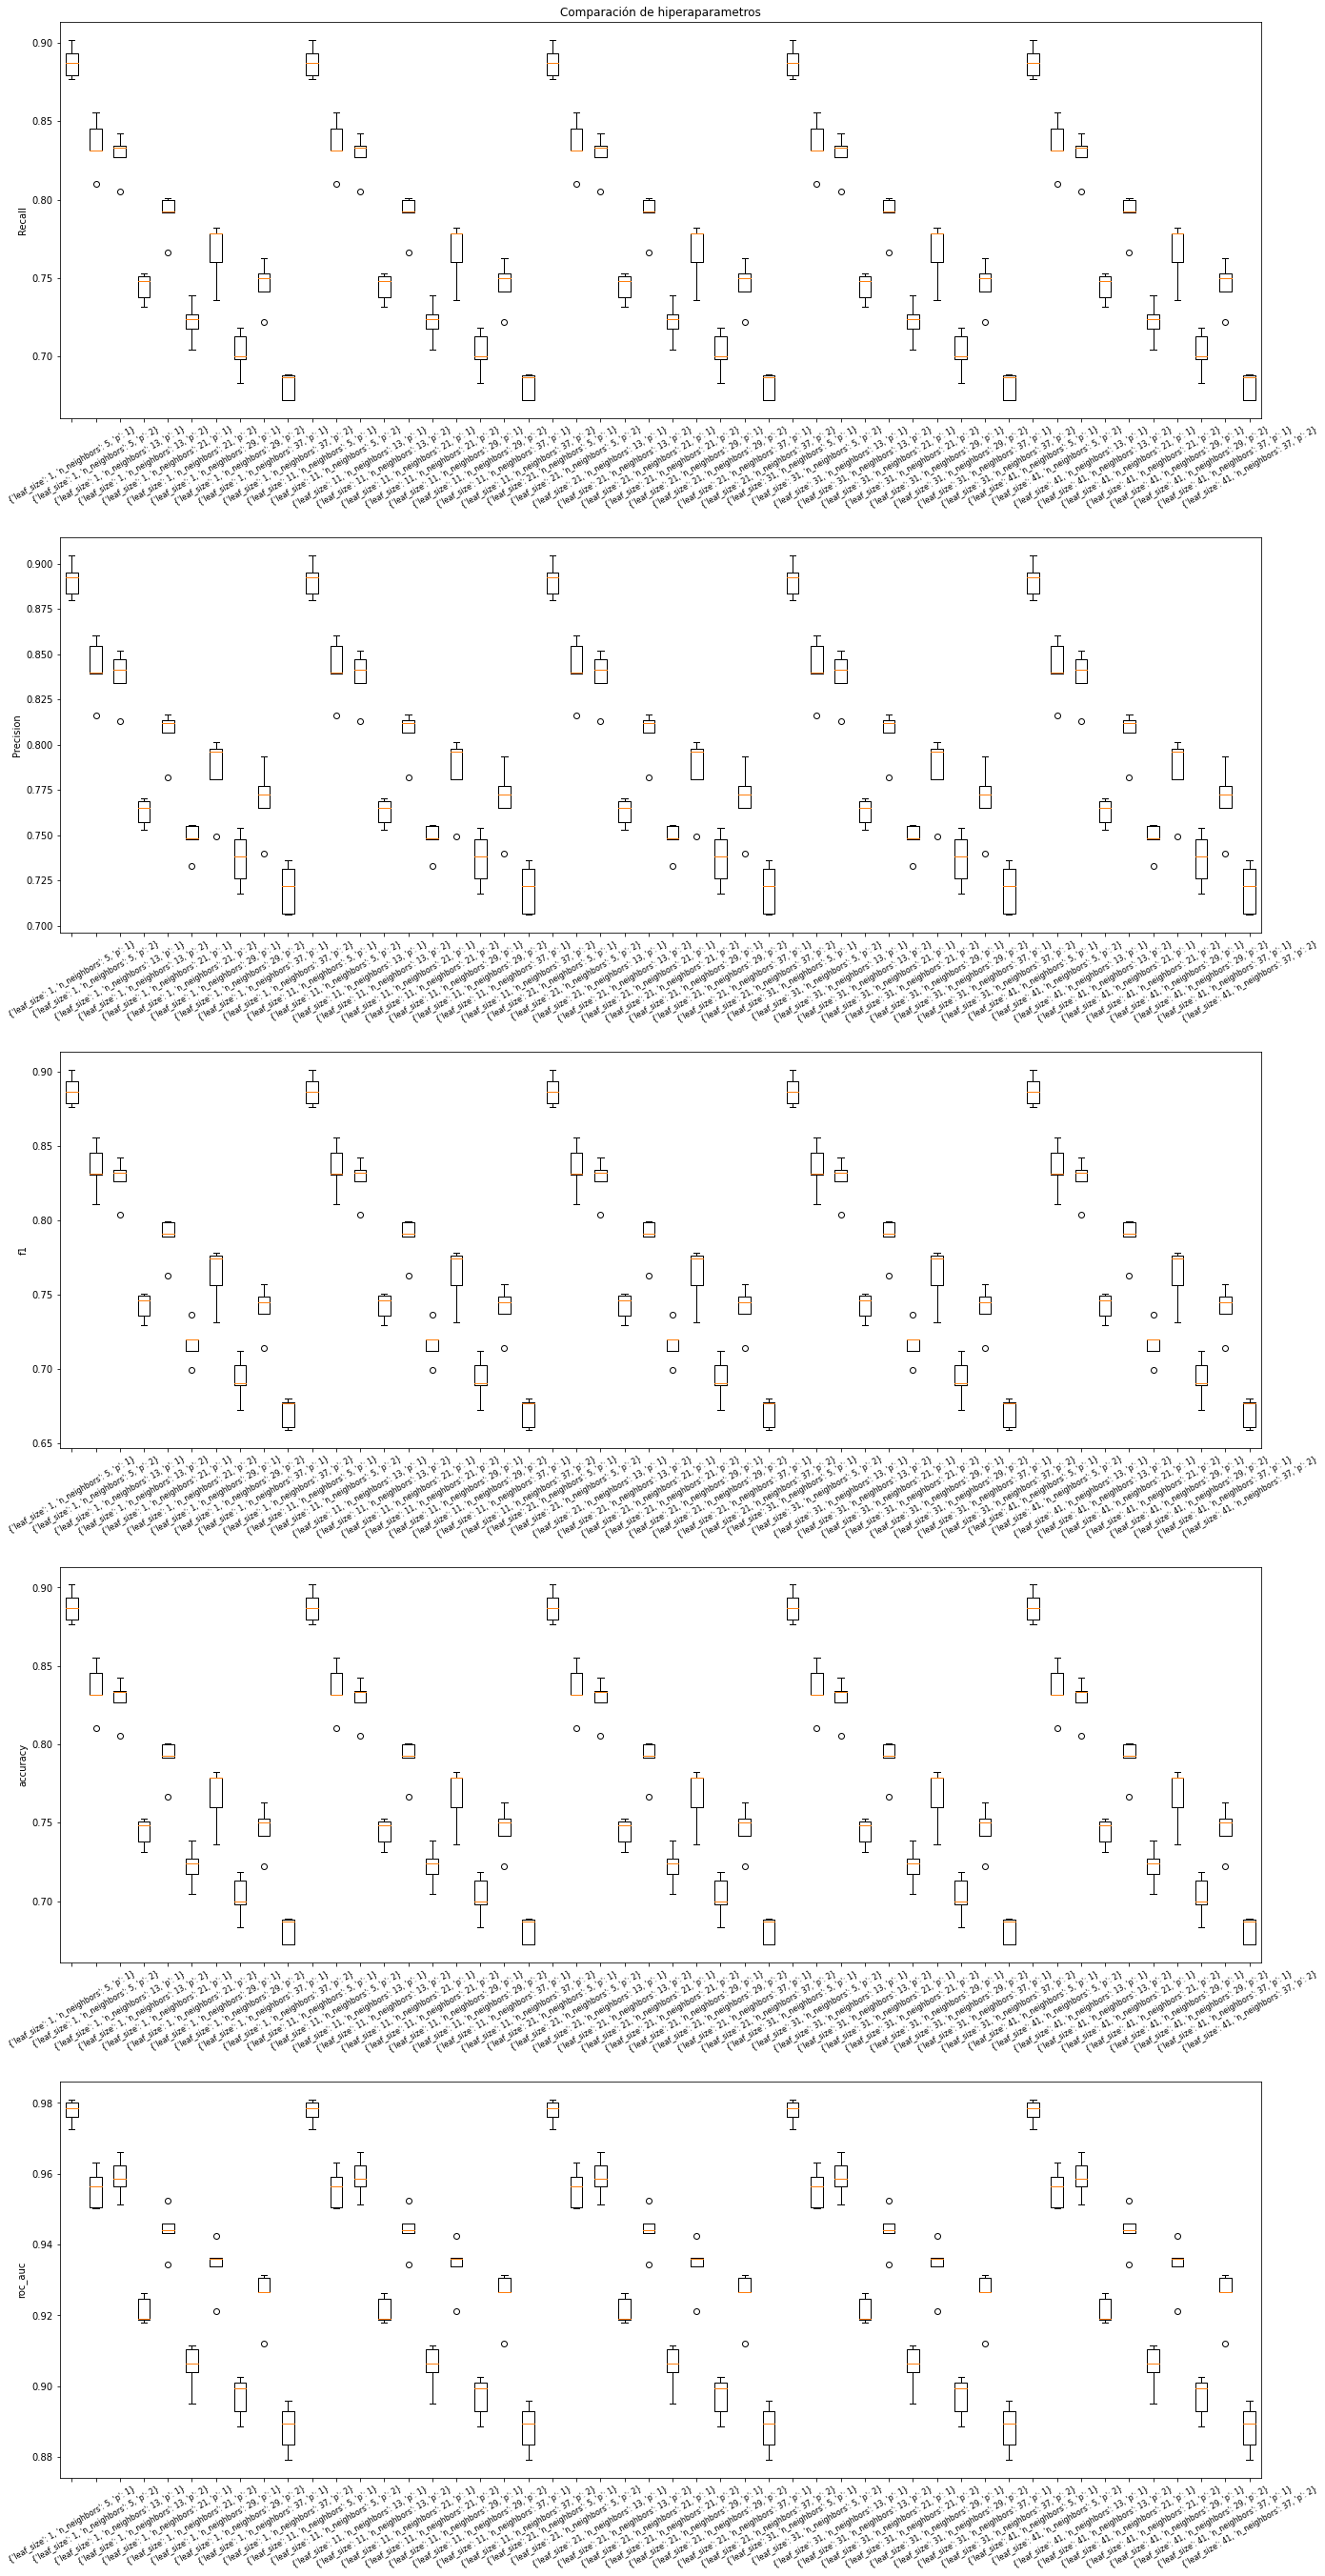

In [66]:

df = pd.DataFrame.from_dict(search_results.cv_results_)
df.to_excel("./informe/tables/parameters_knn.xlsx") 
labels = df['params']

data_recall =[]
data_precision = []
data_f1 =[]
data_accuracy = []
data_roc_auc  =[]


for c in range(len(labels)): 
    data_recall.append(df.iloc[c,8:13].to_list())  
    data_precision.append(df.iloc[c,16:21].to_list())  
    data_f1.append(df.iloc[c,24:29].to_list())  
    data_accuracy.append(df.iloc[c,32:37].to_list())  
    data_roc_auc.append(df.iloc[c,40:45].to_list())    





fig, ax = plt.subplots(5,1)

ax[0].boxplot(data_recall,labels=labels)
ax[0].set_xticklabels(labels=labels,rotation=30, fontsize=8)
ax[0].set(
    axisbelow=True,  # Hide the grid behind plot objects
    title='Comparación de hiperaparametros',
    ylabel='Recall'
    )

ax[1].boxplot(data_precision,labels=labels)
ax[1].set_xticklabels(labels=labels,rotation=30, fontsize=8)
ax[1].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='Precision'
)

ax[2].boxplot(data_f1,labels=labels)
ax[2].set_xticklabels(labels=labels,rotation=30, fontsize=8)
ax[2].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='f1'
)


ax[3].boxplot(data_accuracy,labels=labels)
ax[3].set_xticklabels(labels=labels,rotation=30, fontsize=8)
ax[3].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='accuracy'
)


ax[4].boxplot(data_roc_auc,labels=labels)
ax[4].set_xticklabels(labels=labels,rotation=30, fontsize=8)
ax[4].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='roc_auc'
)
fig.subplots_adjust(left=0.08, right=3, bottom=0.05, top=9,
                    hspace=0.3, wspace=0.3)

plt.show()



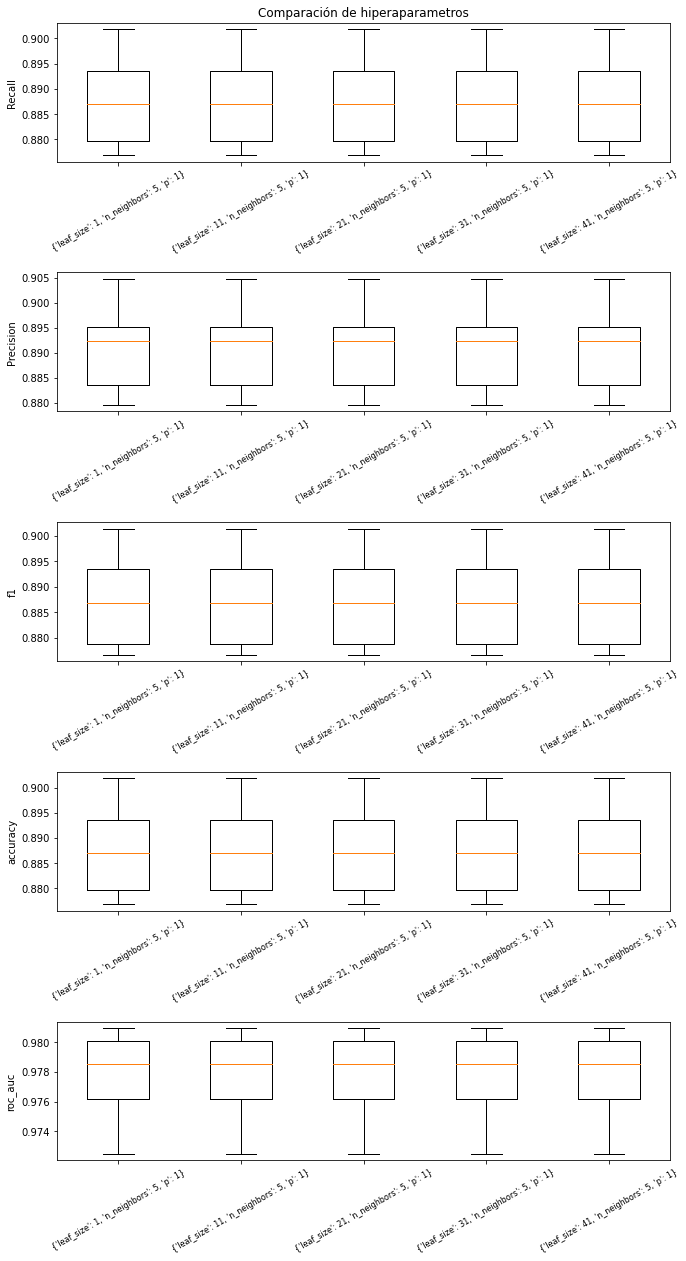

In [74]:
## Mostramos los top 5 que aparecen en los diagramas
top_recall =[]
top_precision = []
top_f1 =[]
top_accuracy = []
top_roc_auc  =[]
top_labels = []


for c in range(len(labels)):
    for score in scoring:        
        x = df['rank_test_'+score]
        if score == 'recall_macro':            
            if x[c] == 1 :
                top_recall.append(df.iloc[c,8:13].to_list())
                top_labels.append(df['params'][c]) 
        elif score == 'precision_macro':
            if x[c] == 1 :
                top_precision.append(df.iloc[c,16:21].to_list())
        elif score == 'f1_macro':
            if x[c] == 1 : 
                top_f1.append(df.iloc[c,24:29].to_list())
        elif score == 'accuracy':
            if x[c] == 1 :
                top_accuracy.append(df.iloc[c,32:37].to_list())
        elif score == 'roc_auc_ovo':
            if x[c] == 1 :
                top_roc_auc.append(df.iloc[c,40:45].to_list())


fig, ax = plt.subplots(5,1)

ax[0].boxplot(top_recall,labels=top_labels)
ax[0].set_xticklabels(labels=top_labels,rotation=30, fontsize=8)
ax[0].set(
    axisbelow=True,  # Hide the grid behind plot objects
    title='Comparación de hiperaparametros',
    ylabel='Recall'
    )

ax[1].boxplot(top_precision,labels=top_labels)
ax[1].set_xticklabels(labels=top_labels,rotation=30, fontsize=8)
ax[1].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='Precision'
)

ax[2].boxplot(top_f1,labels=top_labels)
ax[2].set_xticklabels(labels=top_labels,rotation=30, fontsize=8)
ax[2].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='f1'
)


ax[3].boxplot(top_accuracy,labels=top_labels)
ax[3].set_xticklabels(labels=top_labels,rotation=30, fontsize=8)
ax[3].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='accuracy'
)


ax[4].boxplot(top_roc_auc,labels=top_labels)
ax[4].set_xticklabels(labels=top_labels,rotation=30, fontsize=8)
ax[4].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='roc_auc'
)
fig.subplots_adjust(left=0.08, right=1.5, bottom=0.05, top=4,
                    hspace=0.8, wspace=0.3)

plt.show()
            

 




In [68]:
# Comparacion de hipotesis con accuracy
alpha = 0.05
F_statistic, pVal = stats.kruskal(top_accuracy[0],top_accuracy[1], top_accuracy[2],top_accuracy[3],top_accuracy[4])

print ('p-valor KrusW:', pVal)

if pVal <= alpha:
    print('Rechazamos la hipótesis: los modelos son diferentes\n')
    stacked_data = np.vstack((top_accuracy[0],top_accuracy[1], top_accuracy[2],top_accuracy[3],top_accuracy[4])).ravel()
    stacked_model = np.vstack((np.repeat('modelLR',CV),np.repeat('modelLDA',CV),np.repeat('modelKNN',CV))).ravel()    
    MultiComp = MultiComparison(stacked_data, stacked_model)
    comp = MultiComp.allpairtest(stats.ttest_rel, method='Holm')
    print (comp[0])    
    print(MultiComp.tukeyhsd(alpha=0.05))
else:
    print('Aceptamos la hipótesis: los modelos son iguales')

# Como los modelos son iguales aceptamos el modelo mas sencillo, osea el parametro con la hoja mas grande ya que es el mas rapido 

p-valor KrusW: 1.0
Aceptamos la hipótesis: los modelos son iguales


### Modelo final 

C:\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0, 0.5, 'Clase real')

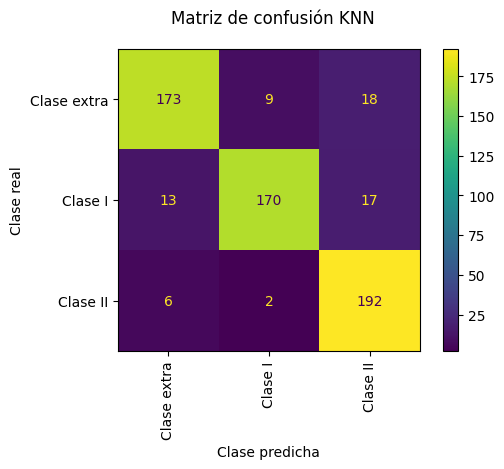

In [69]:
modelKNN = KNeighborsClassifier(n_neighbors=5,leaf_size=41,p=1)
modelKNN.fit(x_train,t_train)
y_predict=modelKNN.predict(x_val)
Clases=['Clase extra','Clase I','Clase II']
disp = plot_confusion_matrix(modelKNN,x_val, t_val, display_labels = Clases, xticks_rotation = 'vertical') # Muestra gráficamente la matriz de confusión
disp.figure_.suptitle("Matriz de confusión KNN");                                                          # Añade un título a la figura de la matriz de confusión
disp.figure_.set_dpi(100)                                                                                  # Establece el tamaño de la figura
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")

### Metricas del conjunto de validación

In [70]:
mcm = multilabel_confusion_matrix(t_val, y_predict)
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]

specificity_score = tn / (tn + fp)

print("recall: "+str(recall_score(t_val,y_predict,average='macro')))
print("precission:"+str(precision_score(t_val,y_predict,average='macro')))
print("f1:"+str(f1_score(t_val,y_predict,average='macro')))
print("accuracy:"+str(accuracy_score(t_val,y_predict)))    
print("roc_auc:"+str(roc_auc_score(t_val,modelKNN.predict_proba(x_val),multi_class='ovr')))
print("specificity: "+ str(np.mean(specificity_score)))


recall: 0.8916666666666666
precission:0.8953610546590838
f1:0.8914463121852156
accuracy:0.8916666666666667
roc_auc:0.9803416666666666
specificity: 0.9458333333333333


### Modelo para comparar con diferentes clasificadores

In [71]:
scoresKNN = cross_validate(modelKNN, x_train, t_train, cv=CV, scoring=scoring)
%store scoresKNN

Stored 'scoresKNN' (dict)
